In [1]:
%load_ext lab_black

In [2]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
representation_size = 2
input_size = 4
n_samples = 10000
batch_size = 500
gen_hidden_size = 200
enc_hidden_size = 200
disc_hidden_size = 200

In [24]:
n_samples_per_batch = n_samples // input_size

y = np.array([i for i in range(input_size) for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)

In [25]:
print(x[[10, 58, 610, 790, 1123, 1258, 1506, 1988]])

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [26]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.gen_l1 = torch.nn.Linear(representation_size, gen_hidden_size)
        self.gen_l2 = torch.nn.Linear(gen_hidden_size, input_size)

        self.enc_l1 = torch.nn.Linear(input_size + representation_size, enc_hidden_size)
        self.enc_l2 = torch.nn.Linear(enc_hidden_size, representation_size)

        self.disc_l1 = torch.nn.Linear(
            input_size + representation_size, disc_hidden_size
        )
        self.disc_l2 = torch.nn.Linear(disc_hidden_size, 1)

        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def sample_prior(self, s):
        if self.training:
            m = torch.zeros((s.data.shape[0], representation_size))
            std = torch.ones((s.data.shape[0], representation_size))
            d = Variable(torch.normal(m, std))
        else:
            d = Variable(torch.zeros((s.data.shape[0], representation_size)))

        return d

    def discriminator(self, x, z):
        i = torch.cat((x, z), dim=1)
        h = self.relu(self.disc_l1(i))
        return self.disc_l2(h)

    def sample_posterior(self, x):
        i = torch.cat((x, self.sample_prior(x)), dim=1)
        h = self.relu(self.enc_l1(i))
        return self.enc_l2(h)

    def decoder(self, z):
        i = self.relu(self.gen_l1(z))
        h = self.sigmoid(self.gen_l2(i))
        return h

    def forward(self, x):
        z_p = self.sample_prior(x)

        z_q = self.sample_posterior(x)
        log_d_prior = self.discriminator(x, z_p)
        log_d_posterior = self.discriminator(x, z_q)
        disc_loss = torch.mean(
            torch.nn.functional.binary_cross_entropy_with_logits(
                log_d_posterior, torch.ones_like(log_d_posterior)
            )
            + torch.nn.functional.binary_cross_entropy_with_logits(
                log_d_prior, torch.zeros_like(log_d_prior)
            )
        )

        x_recon = self.decoder(z_q)
        recon_liklihood = (
            -torch.nn.functional.binary_cross_entropy(x_recon, x) * x.data.shape[0]
        )

        gen_loss = torch.mean(log_d_posterior) - torch.mean(recon_liklihood)

        return disc_loss, gen_loss

In [27]:
model = VAE()
model

VAE(
  (gen_l1): Linear(in_features=2, out_features=200, bias=True)
  (gen_l2): Linear(in_features=200, out_features=4, bias=True)
  (enc_l1): Linear(in_features=6, out_features=200, bias=True)
  (enc_l2): Linear(in_features=200, out_features=2, bias=True)
  (disc_l1): Linear(in_features=6, out_features=200, bias=True)
  (disc_l2): Linear(in_features=200, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [28]:
disc_params = []
gen_params = []
for name, param in model.named_parameters():

    if "disc" in name:

        disc_params.append(param)
    else:
        gen_params.append(param)

In [29]:
disc_optimizer = torch.optim.Adam(disc_params, lr=1e-3)
gen_optimizer = torch.optim.Adam(gen_params, lr=1e-3)

In [30]:
def train(epoch, batches_per_epoch=501, log_interval=500):
    # model.train()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        # data = data, requires_grad=False)

        gen_loss = model(data)[1]

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        discrim_loss = model(data)[0]
        disc_optimizer.zero_grad()
        discrim_loss.backward()
        disc_optimizer.step()
        if (i % log_interval == 0) and (epoch % 1 == 0):
            # Print progress
            print(
                "Train Epoch: {} [{}/{}]\tLoss: {:.6f}\tLoss: {:.6f}".format(
                    epoch,
                    i * batch_size,
                    batch_size * batches_per_epoch,
                    discrim_loss.item() / len(data),
                    gen_loss.item() / len(data),
                )
            )

    print("====> Epoch: {} done!".format(epoch))

In [31]:
for epoch in range(1, 15):
    train(epoch)

Train Epoch: 1 [0/250500]	Loss: 0.002797	Loss: 0.678423
Train Epoch: 1 [250000/250500]	Loss: 0.000667	Loss: 0.005621
====> Epoch: 1 done!
Train Epoch: 2 [0/250500]	Loss: 0.000641	Loss: 0.005700
Train Epoch: 2 [250000/250500]	Loss: 0.000996	Loss: 0.004587
====> Epoch: 2 done!
Train Epoch: 3 [0/250500]	Loss: 0.000930	Loss: 0.004584
Train Epoch: 3 [250000/250500]	Loss: 0.001119	Loss: 0.003434
====> Epoch: 3 done!
Train Epoch: 4 [0/250500]	Loss: 0.001220	Loss: 0.003374
Train Epoch: 4 [250000/250500]	Loss: 0.001349	Loss: 0.003360
====> Epoch: 4 done!
Train Epoch: 5 [0/250500]	Loss: 0.001198	Loss: 0.003332
Train Epoch: 5 [250000/250500]	Loss: 0.001023	Loss: 0.003440
====> Epoch: 5 done!
Train Epoch: 6 [0/250500]	Loss: 0.001044	Loss: 0.003620
Train Epoch: 6 [250000/250500]	Loss: 0.001292	Loss: 0.003199
====> Epoch: 6 done!
Train Epoch: 7 [0/250500]	Loss: 0.001317	Loss: 0.003293
Train Epoch: 7 [250000/250500]	Loss: 0.001229	Loss: 0.002959
====> Epoch: 7 done!
Train Epoch: 8 [0/250500]	Loss: 0.

In [32]:
data = Variable(torch.from_numpy(x), requires_grad=False)

model.train()
zs = model.sample_posterior(data).data.numpy()

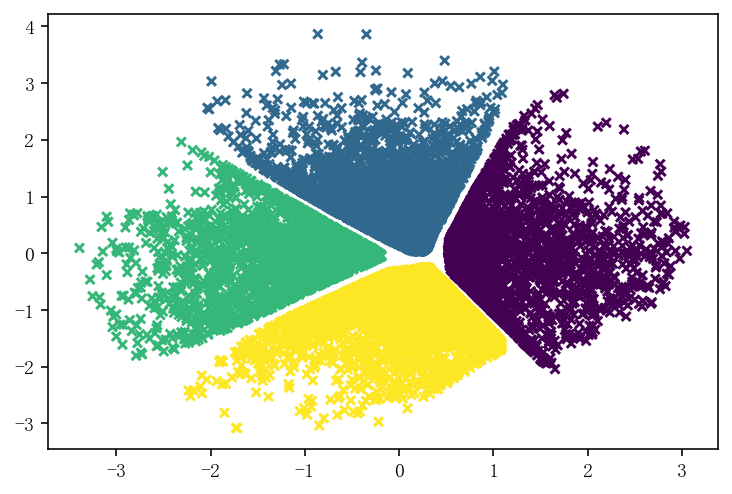

In [33]:
plt.scatter(zs[:, 0], zs[:, 1], c=y, s=20, marker="x")

In [38]:
x = torch.tensor(2.0, requires_grad=True)
y = x ** 4
grad1 = torch.autograd.grad(y, x, create_graph=True, retain_graph=True)
grad2 = torch.autograd.grad(grad1[0], x)

In [39]:
grad2

(tensor(48.),)

In [40]:
torch.nn.functional.binary_cross_entropy_with_logits?

Signature:
torch.nn.functional.binary_cross_entropy_with_logits(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Union[torch.Tensor, NoneType] = None,
    size_average: Union[bool, NoneType] = None,
    reduce: Union[bool, NoneType] = None,
    reduction: str = 'mean',
    pos_weight: Union[torch.Tensor, NoneType] = None,
) -> torch.Tensor
Docstring:
Function that measures Binary Cross Entropy between target and output
logits.

See :class:`~torch.nn.BCEWithLogitsLoss` for details.

Args:
    input: Tensor of arbitrary shape
    target: Tensor of the same shape as input
    weight (Tensor, optional): a manual rescaling weight
        if provided it's repeated to match input tensor shape
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the field :attr:`size_average`
        is set to ``False``, the 

In [41]:
from scipy.stats import norm, uniform

In [137]:
x1 = np.random.uniform(low=-20, high=20, size=(300, 1))
x2 = np.random.normal(loc=5, scale=2, size=(300, 1))

y1 = np.zeros_like(x1)
y2 = np.ones_like(x2)

In [161]:
def basis(x):
    """A Basis function that is sufficiently flexible to model the problem."""
    return np.concatenate([x, x ** 2], axis=1)

In [162]:
x = np.concatenate([x1, x2])

x = basis(x)

y = np.concatenate([y1, y2]).ravel()

In [163]:
from sklearn.linear_model import LogisticRegression

In [164]:
lr = LogisticRegression()
lr.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
xtest_ = np.arange(-10, 20).reshape(-1, 1)
# xtest = basis(xtest_)

In [166]:
ps = lr.predict_proba(xtest)

In [167]:
est = ps[:, 1] / ps[:, 0]

In [168]:
truth = norm.pdf(xtest_, loc=5, scale=2,) * 40  # p(x)/q(x)

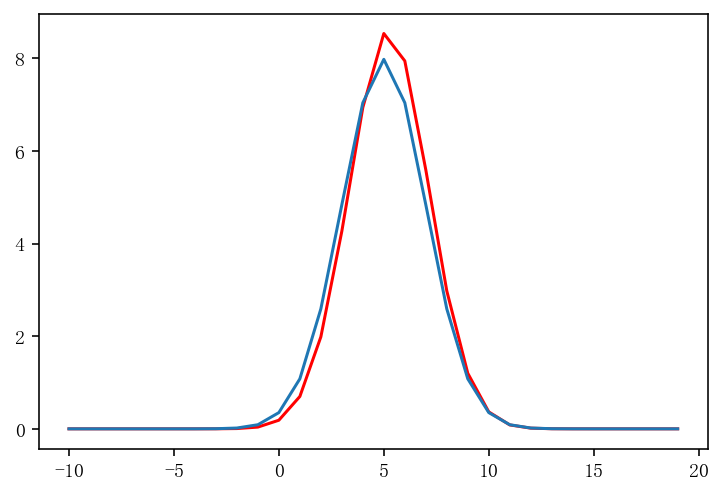

In [169]:
plt.plot(xtest_, est, c="r")
plt.plot(xtest_, truth)

array([[ 1.62258392e-01,  2.63277859e-02],
       [ 7.84045055e+00,  6.14726648e+01],
       [-1.26386664e+00,  1.59735889e+00],
       ...,
       [ 2.85798727e+00,  8.16809122e+00],
       [ 5.87977296e+00,  3.45717300e+01],
       [ 3.31157230e+00,  1.09665111e+01]])

In [340]:
x1 = np.random.uniform(low=-20, high=20, size=(300, 1))
x2 = np.random.normal(loc=5, scale=2, size=(300, 1))

y1 = np.zeros_like(x1)
y2 = np.ones_like(x2)

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2]).ravel()
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).view(-1, 1).float()

In [341]:
class BP(nn.Module):
    def __init__(self, inputs=1, hidden=1000, output=1):
        super(BP, self).__init__()
        self.linear1 = nn.Linear(inputs, hidden)
        self.linear2 = nn.Linear(hidden, output)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [342]:
# x = torch.tensor([[1.0]])
model = BP()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epoch = 2000
for epoch in range(num_epoch):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

In [343]:
xtest = torch.arange(-10, 20, 0.1).reshape(-1, 1)

In [344]:
est = model(xtest).detach() / (1 - model(xtest).detach())
true = torch.exp(torch.distributions.Normal(5, 2).log_prob(xtest)) * 40

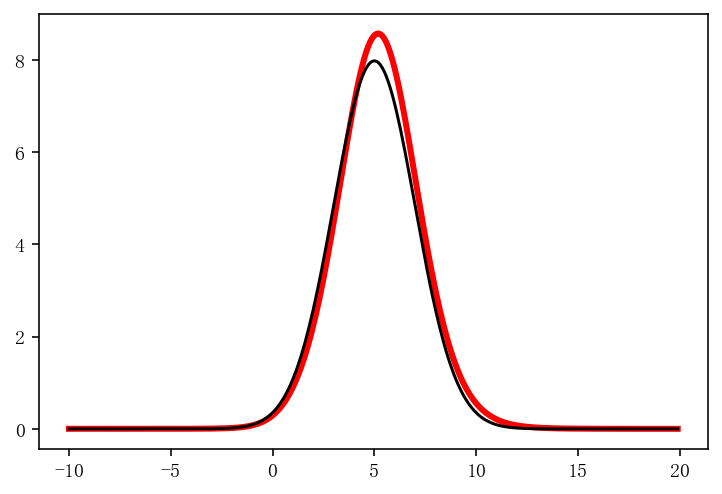

In [345]:
plt.plot(xtest, est, c="r", label="Estimator", lw=3)
plt.plot(xtest, true, label="True", c="k")

In [346]:
loss

tensor(0.0937, grad_fn=<MseLossBackward>)